XGBoost and SHAP classifiaction

In [12]:
import os, warnings, numpy as np, pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)

print("xgboost:", xgb.__version__)
print("shap:", shap.__version__)

TREE_METHOD = "hist"  # CPU-friendly


xgboost: 3.0.4
shap: 0.48.0


In [11]:
csv_path = "data.csv"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    source = "Folder CSV"

print("Source:", source, "| Shape:", df.shape)
df.head(3)


Source: Folder CSV | Shape: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [16]:
drop_cols = [c for c in ["id", "Unnamed: 32"] if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)

y = (df["diagnosis"] == "M").astype(int)  # M->1, B->0
X = df.drop(columns=["diagnosis"])

print("Num features:", X.shape[1])
print("Class distribution (1=Malignant):")
print(y.value_counts(normalize=True).rename("ratio"))

X.head(3)

Num features: 30
Class distribution (1=Malignant):
diagnosis
0    0.627417
1    0.372583
Name: ratio, dtype: float64


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [18]:
import inspect, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Common params
params = dict(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",     # CPU-friendly
    eval_metric="logloss",
    random_state=42
)

# --- Detect sklearn-API capabilities on your installation ---
fit_params = inspect.signature(xgb.XGBClassifier.fit).parameters
has_callbacks = "callbacks" in fit_params
has_esr = "early_stopping_rounds" in fit_params  # ESR

model = xgb.XGBClassifier(**params)
booster = None  # will hold xgb.Booster if we use native API

if has_callbacks:
    # XGBoost >= 3.x sklearn-API path (EarlyStopping via callbacks)
    from xgboost.callback import EarlyStopping
    early_stop = EarlyStopping(rounds=50, min_delta=0.0, save_best=True, maximize=False)

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
        callbacks=[early_stop]
    )

    proba_test = model.predict_proba(X_test)[:, 1]
    best_iter = getattr(model, "best_iteration", None)

elif has_esr:
    # Older sklearn-API path (supports early_stopping_rounds directly)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
        early_stopping_rounds=50
    )

    proba_test = model.predict_proba(X_test)[:, 1]
    best_iter = getattr(model, "best_iteration", None)

else:
    # Fallback to native xgb.train with early stopping (works very broadly)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test,  label=y_test)

    train_params = {
        "objective": "binary:logistic",
        "eta": params["learning_rate"],
        "max_depth": params["max_depth"],
        "subsample": params["subsample"],
        "colsample_bytree": params["colsample_bytree"],
        "tree_method": params["tree_method"],
        "eval_metric": "logloss",
        "verbosity": 0,
        "seed": params["random_state"]
    }

    try:
        # Try native early_stopping_rounds arg
        booster = xgb.train(
            params=train_params,
            dtrain=dtrain,
            num_boost_round=params["n_estimators"],
            evals=[(dvalid, "valid")],
            early_stopping_rounds=50,
            verbose_eval=False
        )
    except TypeError:
        # If your version needs callbacks instead
        from xgboost.callback import EarlyStopping
        booster = xgb.train(
            params=train_params,
            dtrain=dtrain,
            num_boost_round=params["n_estimators"],
            evals=[(dvalid, "valid")],
            callbacks=[EarlyStopping(rounds=50, save_best=True, maximize=False)],
            verbose_eval=False
        )

    # Probabilities from Booster (handle best-iteration across versions)
    if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
        proba_test = booster.predict(dvalid, iteration_range=(0, booster.best_iteration + 1))
        best_iter = booster.best_iteration
    else:
        # Older fallback
        proba_test = booster.predict(dvalid, ntree_limit=getattr(booster, "best_ntree_limit", 0) or 0)
        best_iter = getattr(booster, "best_iteration", None)

auc = roc_auc_score(y_test, proba_test)
print(f"AUC (test): {auc:.4f}")
print("Best iteration:", best_iter)

# This is what SHAP should use in the next cells:
explainer_model = booster if booster is not None else model


AUC (test): 0.9960
Best iteration: 237


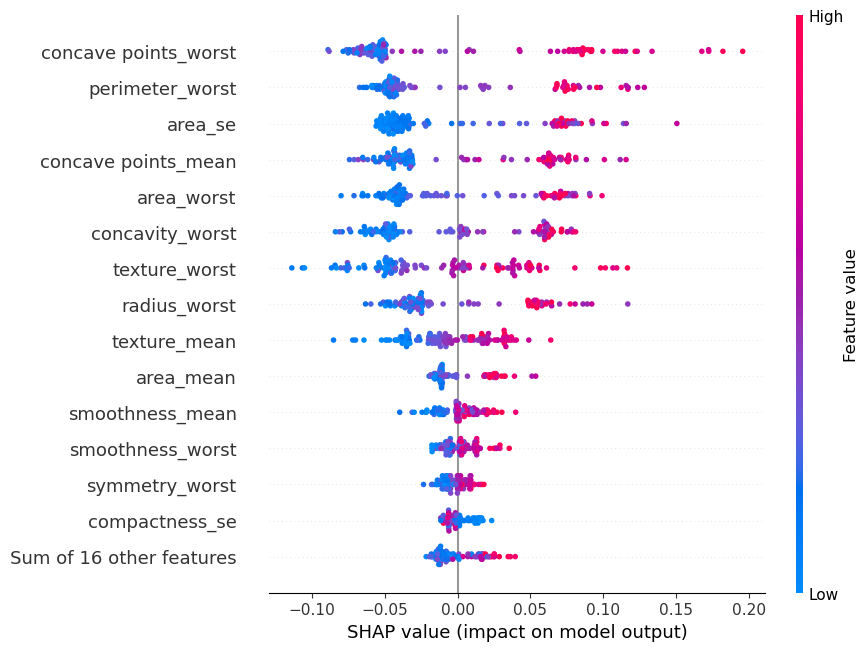

In [20]:
import shap, matplotlib.pyplot as plt

shap.initjs()

# Use a small background sample from TRAIN for interventional SHAP
background = shap.utils.sample(X_train, 200, random_state=42)

X_shap = X_test.copy()

explainer = shap.TreeExplainer(
    explainer_model,                # model or Booster from the training cell
    data=background,                # background dataset enables "interventional"
    feature_perturbation="interventional",
    model_output="probability"      # now supported with interventional
)

# In probability space additivity is approximate; silence the check to avoid warnings
sv = explainer(X_shap, check_additivity=False)

shap.plots.beeswarm(sv, max_display=15)
plt.show()
